In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn.metrics
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [92]:
# Artificial dataset
xtrain = np.arange(-5, 5).reshape(-1,1)
noise = 0.2
ytrain = np.sin(xtrain) + np.random.normal(0, noise, size=(len(xtrain),1))
n_t = len(xtrain)

In [93]:
# Test data
n_s = 100
xtest = np.linspace(-5, 5, n_s).reshape(-1,1)
xtest.shape

(100, 1)

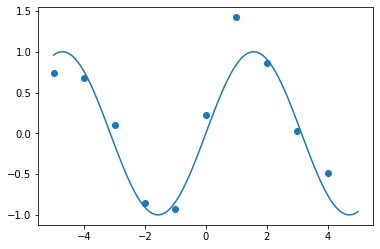

In [94]:
plt.scatter(xtrain, ytrain)
plt.plot(xtest, np.sin(xtest))

In [95]:
#Defining the kernel (Radial Basis Function kernel)
def kernel(a, b, l=1, sig_var=1):
    distance = np.zeros((a.shape[0], b.shape[0]))
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            distance[i][j] = np.linalg.norm(a[i][0] - b[j][0])
    return sig_var**2 * np.exp(-1/(2+l**2) * distance**2)

## Prior

[[1.    0.997 0.986 ... 0.    0.    0.   ]
 [0.997 1.    0.997 ... 0.    0.    0.   ]
 [0.986 0.997 1.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 1.    0.997 0.986]
 [0.    0.    0.    ... 0.997 1.    0.997]
 [0.    0.    0.    ... 0.986 0.997 1.   ]]


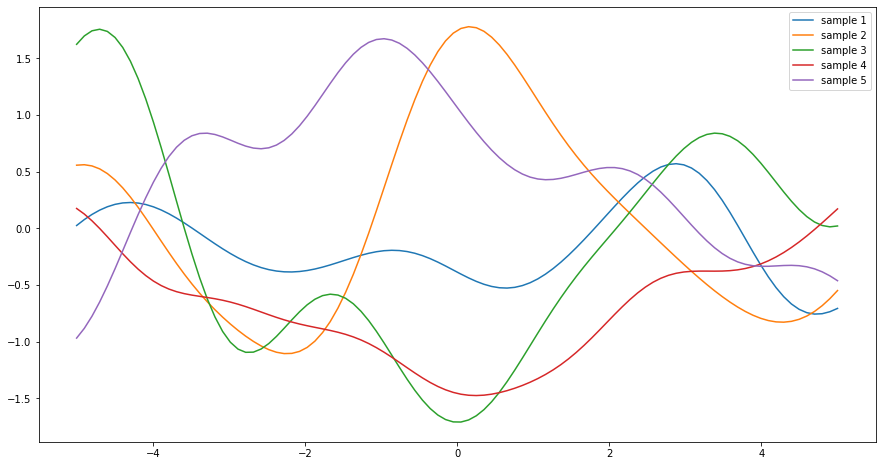

In [96]:
K_ss = kernel(xtest, xtest)
print(K_ss)

# Drawing 5 samples
f_prior = np.random.multivariate_normal(mean=np.zeros(n_s), cov=K_ss, size=5).T

plt.figure(figsize=(15,8))
plt.plot(xtest, f_prior, label=["sample 1", "sample 2", "sample 3", "sample 4", "sample 5"])
plt.legend()

## Posterior

In [85]:
noise = 0.1 # sigma^2
# K(X,X)
K = kernel(xtrain, xtrain)
# K(X',X')
K_ss = kernel(xtest, xtest)
# K(X,X') = K(X',X).T
K_s = kernel(xtrain, xtest)
k_inv = np.linalg.inv(K + noise*np.eye(n_t))

mean = K_s.T@k_inv@ytrain.squeeze()
cov = K_ss-K_s.T@k_inv@K_s
std = np.sqrt(np.diag(cov)).squeeze()

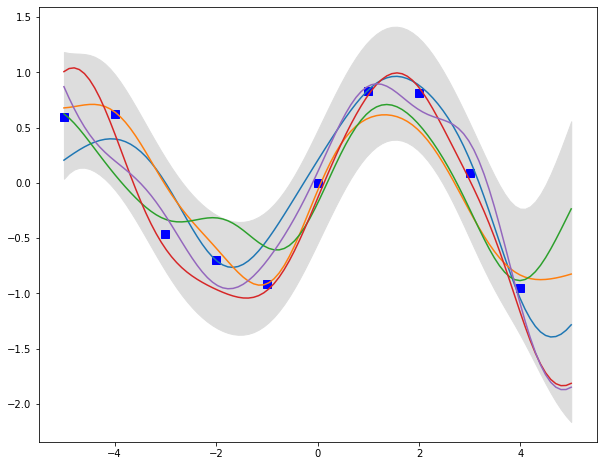

In [86]:
f_post = np.random.multivariate_normal(mean=mean, cov=cov, size=5).T

plt.figure(figsize=(10,8))
plt.plot(xtrain, ytrain, 'bs', ms=8)
plt.plot(xtest, f_post)
# plt.axis([-10,10, -5,5])
plt.gca().fill_between(xtest.flat, mean-2*std, mean+2*std, color="#dddddd")


# Gaussian Processes by Martin Krasser

In [27]:
import numpy as np
from gp_utils import *
%matplotlib inline

In [28]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

## Prior

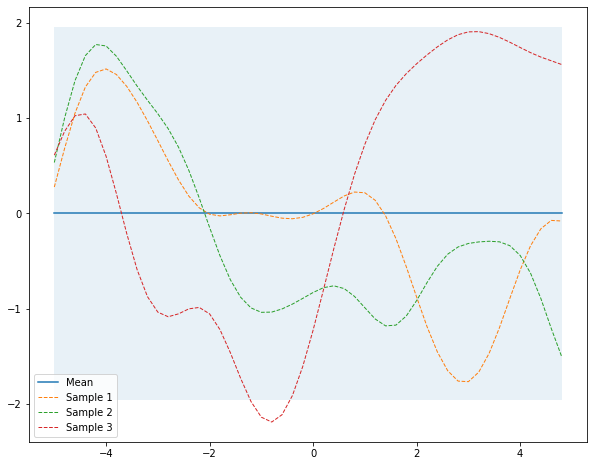

In [29]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1,1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X,X)

# Draw 3 samples from the prior
samples = np.random.multivariate_normal(mean=mu.ravel(), cov= cov, size=3)

plt.figure(figsize=(10,8))
plot_gp(mu, cov, X, samples=samples)

# Prediction from noise free data

In [30]:
def posterior(X_s, X_train, Y_train, l=1., sigma_f = 1., sigma_y = 1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

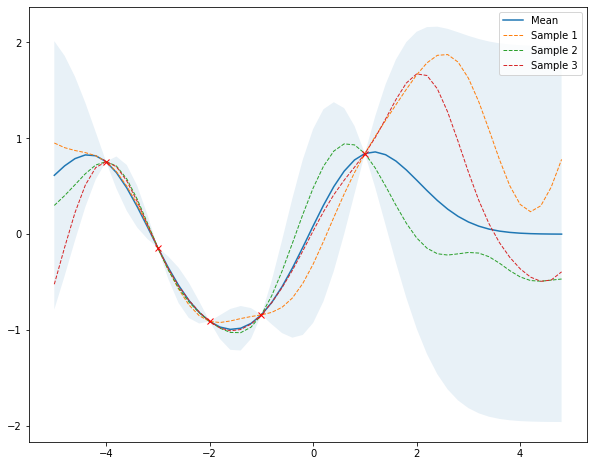

In [31]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
Y_train = np.sin(X_train)

mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plt.figure(figsize=(10,8))
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

## Prediction from noisy data

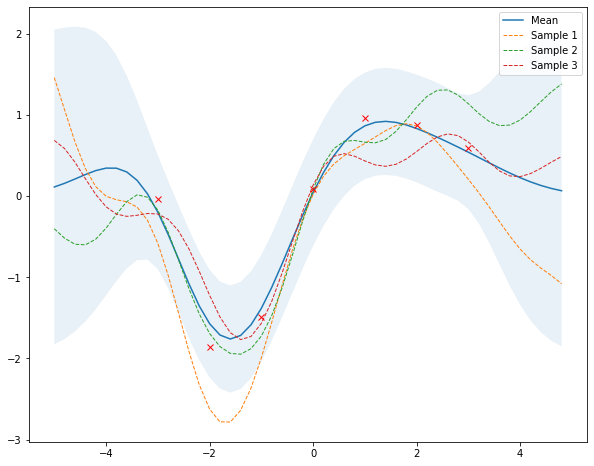

In [32]:
noise = 0.4

X_train = np.arange(-3, 4, 1).reshape(-1,1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plt.figure(figsize=(10,8))
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

## Effect of kernel parameters and noise parameters

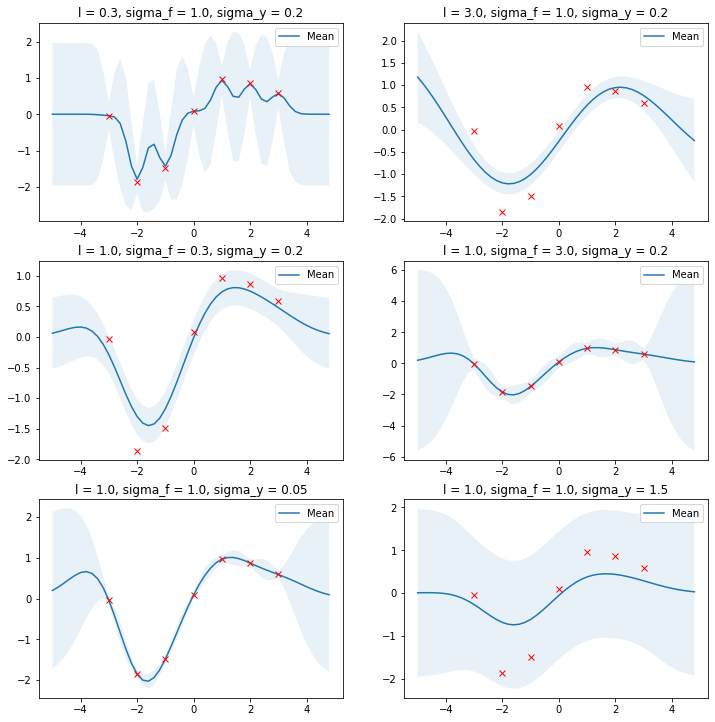

In [33]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, Y_train, l=l, 
                            sigma_f=sigma_f, 
                            sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

## Higher dimensions

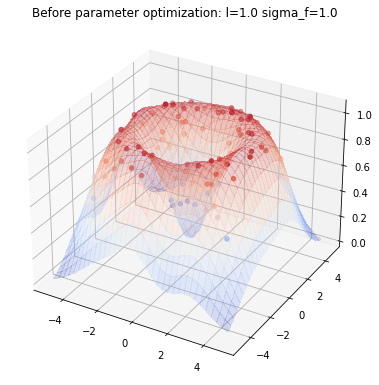

In [41]:
noise_2D = 0.0

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, ry)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100,2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

## Using scikit learn library for gaussian process updates

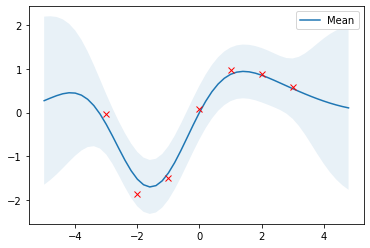

In [46]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)

gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

gpr.fit(X_train, Y_train)

mu_s, cov_s = gpr.predict(X, return_cov=True)

# obtain optimised kernel params
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)